<a href="https://colab.research.google.com/github/taliyameyswara/star-galaxy-classification/blob/main/star_galaxy_classification_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **🌌Star Galaxy Classification Experiment**
Eksperimen ini dibuat untuk membandingkan arsitektur CNN seperti VGG16, MobileNetV2
> 💅Taliya Meyswara - taliyameyswara@gmail.com

# 🔬 **Overview**
<div style="background-color:#fff1cc; padding: 20px;">
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">Penelitian di bidang astronomi terus berkembang. Penelitian ini menyelidiki efisiensi dua struktur convolutional neural network (CNN), yaitu VGG-16 dan MobileNetV2, dalam mengklasifikasikan gambar astronomi bintang dan galaksi dengan menggunakan informasi dari dataset STRIPE82 Star-Galaxy. Model-model ini dianalisis berdasarkan metrik F1-score dan pengukuran akurasi.</p>

# 🔋 **Mempersiapkan Dataset**
Dataset yang digunakan adalah [STRIPE82 Star and Galaxy Dataset](http:////skyserver.sdss.org/dr18/VisualTools/list) yang dibuat oleh [The Sloan Digital Sky Survey (SDSS)](https://skyserver.sdss.org/). Dataset ini kemudian diunggah ke Kaggle sebagai [Dataset Star-Galaxy](http://www.kaggle.com/datasets/siddharthchaini/stars-and-galaxies/data).

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stripe82-star-galaxy/star-galaxy/galaxy/galaxy_187.png
/kaggle/input/stripe82-star-galaxy/star-galaxy/galaxy/galaxy_4062.png
/kaggle/input/stripe82-star-galaxy/star-galaxy/galaxy/galaxy_3160.png
/kaggle/input/stripe82-star-galaxy/star-galaxy/galaxy/galaxy_4166.png
/kaggle/input/stripe82-star-galaxy/star-galaxy/galaxy/galaxy_3797.png
/kaggle/input/stripe82-star-galaxy/star-galaxy/galaxy/galaxy_2793.png
/kaggle/input/stripe82-star-galaxy/star-galaxy/galaxy/galaxy_2754.png
/kaggle/input/stripe82-star-galaxy/star-galaxy/galaxy/galaxy_1305.png
/kaggle/input/stripe82-star-galaxy/star-galaxy/galaxy/galaxy_3425.png
/kaggle/input/stripe82-star-galaxy/star-galaxy/galaxy/galaxy_65.png
/kaggle/input/stripe82-star-galaxy/star-galaxy/galaxy/galaxy_2868.png
/kaggle/input/stripe82-star-galaxy/star-galaxy/galaxy/galaxy_1749.png
/kaggle/input/stripe82-star-galaxy/star-galaxy/galaxy/galaxy_1087.png
/kaggle/input/stripe82-star-galaxy/star-galaxy/galaxy/galaxy_2551.png
/kaggle/input/stripe82-

# 🏗️ Import Library
Code berikut mengimpor beberapa library data science, termasuk TensorFlow, scikit-learn dan mendefinisikan model neural network menggunakan arsitektur MobileNetV2 dan VGG16

In [ ]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

2024-08-21 07:13:14.230143: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 07:13:14.230205: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 07:13:14.232258: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules loaded


# 📥Load and Transform Data

In [ ]:
data_path = "/kaggle/input/stripe82-star-galaxy/star-galaxy"

images = []
labels = []

for subfolder in os.listdir(data_path):

    subfolder_path = os.path.join(data_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue

    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)

        labels.append(subfolder)

data = pd.DataFrame({'image': images, 'label': labels})

# 🔭 Visualisasi data dari dataset

In [ ]:
data.head()

,image,label
0,/kaggle/input/stripe82-star-galaxy/star-galaxy...,galaxy
1,/kaggle/input/stripe82-star-galaxy/star-galaxy...,galaxy
2,/kaggle/input/stripe82-star-galaxy/star-galaxy...,galaxy
3,/kaggle/input/stripe82-star-galaxy/star-galaxy...,galaxy
4,/kaggle/input/stripe82-star-galaxy/star-galaxy...,galaxy


In [ ]:
data.shape

(10000, 2)

# **✂️ Split Dataset**

In [ ]:
strat = data['label']
train_df, dummy_df = train_test_split(data,
                                      train_size= 0.8,
                                      shuffle= True,
                                      random_state= 123,
                                      stratify= strat)

strat = dummy_df['label']
valid_df, test_df = train_test_split(dummy_df,
                                     train_size= 0.5,
                                     shuffle= True,
                                     random_state= 123,
                                     stratify= strat)

In [ ]:
print("Training set shape:", train_df.shape)
print("Validation set shape:", valid_df.shape)
print("Test set shape:", test_df.shape)

Training set shape: (8000, 2)
Validation set shape: (1000, 2)
Test set shape: (1000, 2)


In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
batch_size = 32

In [ ]:
train_generator = ImageDataGenerator()
test_generator = ImageDataGenerator()

train_gen = train_generator.flow_from_dataframe(train_df,
                                       x_col='image',
                                       y_col='label',
                                       target_size=img_size,
                                       class_mode='binary',
                                       color_mode='rgb',
                                       shuffle=True,
                                       batch_size=batch_size)

valid_gen = test_generator.flow_from_dataframe(valid_df,
                                       x_col='image',
                                       y_col='label',
                                       target_size=img_size,
                                       class_mode='binary',
                                       color_mode='rgb',
                                       shuffle=True,
                                       batch_size=batch_size)

test_gen = test_generator.flow_from_dataframe(test_df,
                                      x_col='image',
                                      y_col='label',
                                      target_size=img_size,
                                      class_mode='binary',
                                      color_mode='rgb',
                                      shuffle=False,
                                      batch_size=batch_size)


Found 8000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


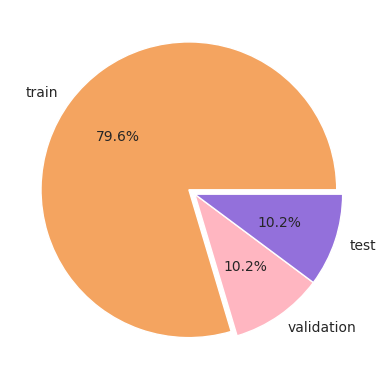

In [ ]:
plt.pie([len(train_gen), len(valid_gen), len(test_gen)],
        labels=['train', 'validation', 'test'], autopct='%.1f%%', colors=['sandybrown', 'lightpink', 'mediumpurple'], explode=(0.05, 0, 0))
plt.show()
# plt.savefig('dataset_pie.png')

In [ ]:
print(train_gen.class_indices)
print(test_gen.class_indices)
print(valid_gen.class_indices)

{'galaxy': 0, 'star': 1}
{'galaxy': 0, 'star': 1}
{'galaxy': 0, 'star': 1}


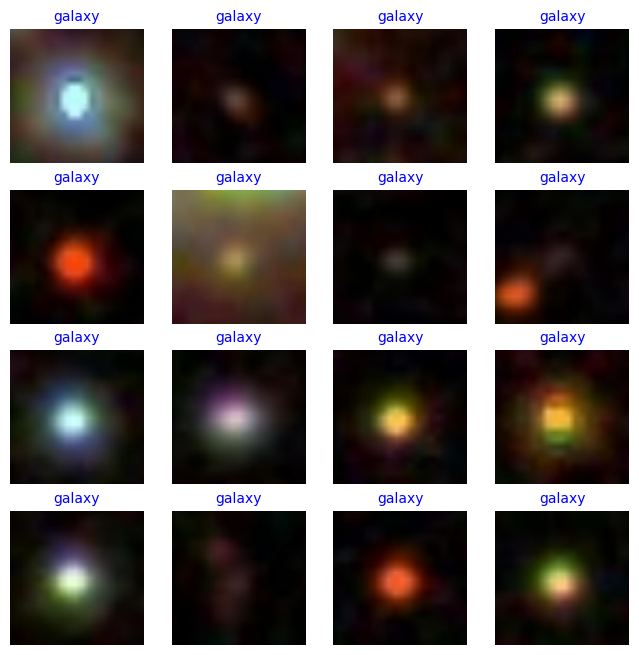

In [ ]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize=(8, 8))

# Pilih 16 indeks acak dari batch gambar
random_indices = np.random.choice(images.shape[0], 16, replace=False)

for i, idx in enumerate(random_indices):
    plt.subplot(4, 4, i + 1)
    image = images[idx] / 255
    plt.imshow(image)
    index = np.argmax(labels[idx])
    class_name = classes[index]
    plt.title(class_name, color='blue', fontsize=10)
    plt.axis('off')
plt.show()

# 🤹Training the model
<div style="background-color:#fff1cc; padding: 20px;">
  <p style="font-size:15px; font-family:verdana; line-height: 1.7em">Model yang akan diuji pada eksperimen kali ini yaitu:</p>
    <ul style="font-size:15px; font-family:verdana; line-height: 1.7em">
        <li>CNN Model</li>
        <li>VGG-16</li>
        <li>MobileNetV2</li>
        <li>ResNet50</li>
    </ul>
    

  <p style="font-size:15px">
    <strong>Batch size</strong>: 32<br>
    <strong>Epochs</strong>: 30<br>
    <strong>Input Shape</strong>: (224, 224, 3)<br>
    <strong>Learning Rate</strong>: 0.001<br>
<!--     <strong>Output layer</strong>: 525 -->
  </p>
</div>

# **1️⃣ CNN Model**

In [ ]:
model = Sequential()

model.add(tf.keras.layers.InputLayer(input_shape=img_shape))

# Layer 1
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

# Layer 2
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

# Layer 3
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Layer 4
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Layer 5
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Flatten Layer
model.add(Flatten())

# Dropout Layer
model.add(Dropout(0.3))

# Dense Layer (Fully Connected Layer)
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))

# Binary Classification Output Layer
model.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 110, 110, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 53, 53, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 51, 51, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 49, 49, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 22, 22, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 20, 20, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 429,825 (1.64 MB)

 Trainable params: 429,185 (1.64 MB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
epochs = 30
batch_size = 32
lr = 0.0001

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback

class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.98:
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

model.compile(optimizer=Adamax(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

history_cnn = model.fit(
    train_gen,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[callbacks]
)

Epoch 1/30


I0000 00:00:1724224447.371943    1842 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1724224447.396719    1842 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.8058 - loss: 0.4751

W0000 00:00:1724224499.232945    1840 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


250/250 ━━━━━━━━━━━━━━━━━━━━ 107s 249ms/step - accuracy: 0.8059 - loss: 0.4748 - val_accuracy: 0.5000 - val_loss: 1.6516
Epoch 2/30


W0000 00:00:1724224509.538242    1840 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


250/250 ━━━━━━━━━━━━━━━━━━━━ 58s 226ms/step - accuracy: 0.8993 - loss: 0.3044 - val_accuracy: 0.7200 - val_loss: 0.6417
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 58s 226ms/step - accuracy: 0.9067 - loss: 0.2864 - val_accuracy: 0.5870 - val_loss: 1.0503
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 58s 224ms/step - accuracy: 0.9097 - loss: 0.2632 - val_accuracy: 0.5270 - val_loss: 1.2182
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 58s 224ms/step - accuracy: 0.9246 - loss: 0.2526 - val_accuracy: 0.6680 - val_loss: 0.7131
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 57s 223ms/step - accuracy: 0.9211 - loss: 0.2430 - val_accuracy: 0.5270 - val_loss: 1.2341
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 56s 219ms/step - accuracy: 0.9259 - loss: 0.2440 - val_accuracy: 0.5760 - val_loss: 1.0165
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 57s 223ms/step - accuracy: 0.9297 - loss: 0.2334 - val_accuracy: 0.6960 - val_loss: 0.7825
Epoch 9/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 59s 228ms/step - accuracy: 0.9316 - loss: 0.2273 - val

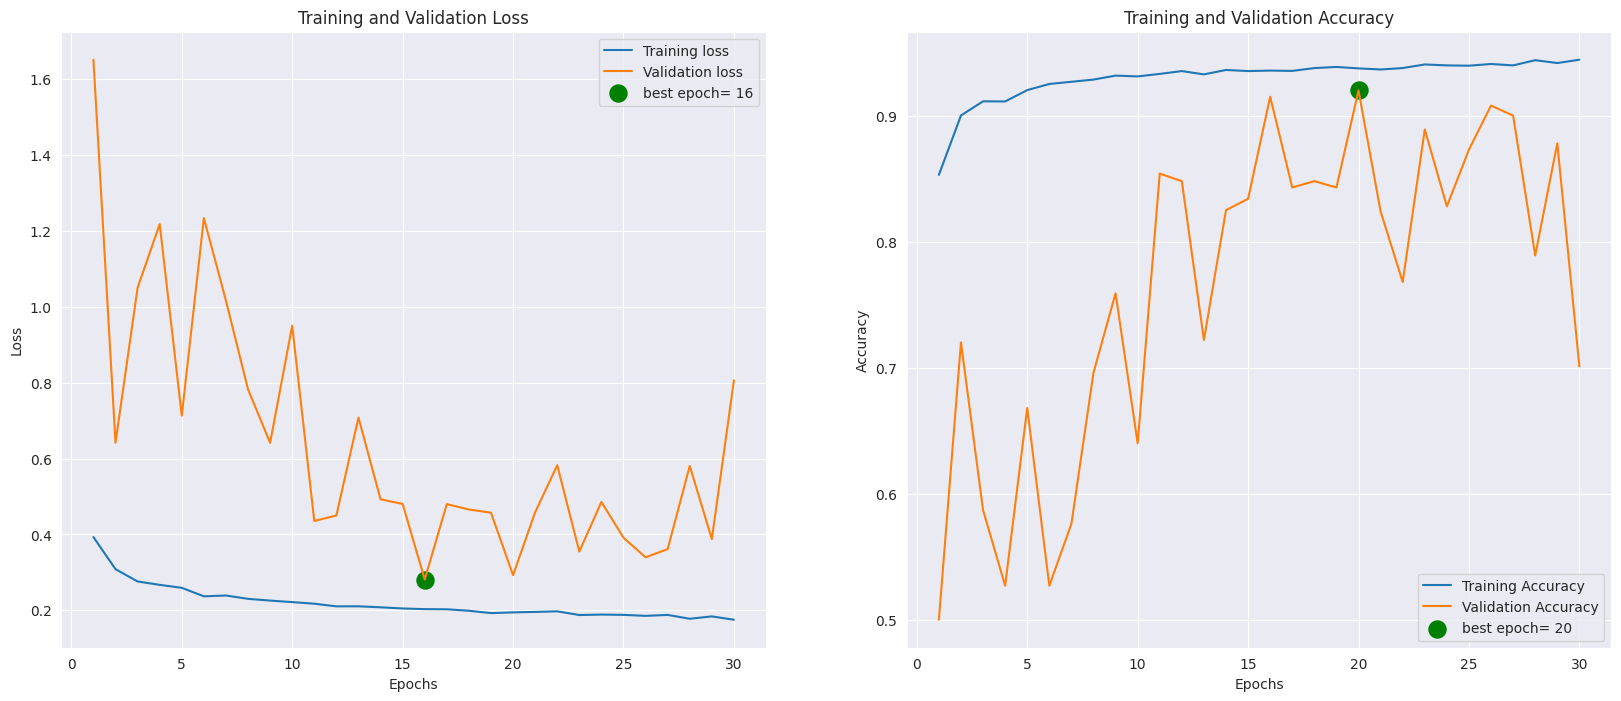

In [ ]:
tr_acc = history_cnn.history['accuracy']
tr_loss = history_cnn.history['loss']
val_acc = history_cnn.history['val_accuracy']
val_loss = history_cnn.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
# plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, label= 'Training Accuracy')
plt.plot(Epochs, val_acc, label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'green', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, label= 'Training loss')
plt.plot(Epochs, val_loss, label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'green', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
loss, accuracy = model.evaluate(valid_gen)
print("Accuracy score:", accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.6984 - loss: 0.8187
Accuracy score: 0.7009999752044678


In [ ]:
train_score = model.evaluate(train_gen, steps=train_gen.samples // batch_size, verbose=1)
valid_score = model.evaluate(valid_gen, steps=valid_gen.samples // batch_size, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]:.4f}")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]:.4f}")
print('-' * 20)


250/250 ━━━━━━━━━━━━━━━━━━━━ 49s 196ms/step - accuracy: 0.7144 - loss: 0.7852
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - accuracy: 0.6991 - loss: 0.7598
Train Loss: 0.7919
Train Accuracy: 0.7132
--------------------
Validation Loss: 0.8060
Validation Accuracy: 0.7016
--------------------


In [ ]:
preds = model.predict(test_gen)
y_pred = np.round(preds).astype(int)

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step


In [ ]:
print(classification_report(test_gen.classes, y_pred, target_names=classes))

              precision    recall  f1-score   support

      galaxy       0.63      0.99      0.77       500
        star       0.97      0.43      0.59       500

    accuracy                           0.71      1000
   macro avg       0.80      0.71      0.68      1000
weighted avg       0.80      0.71      0.68      1000



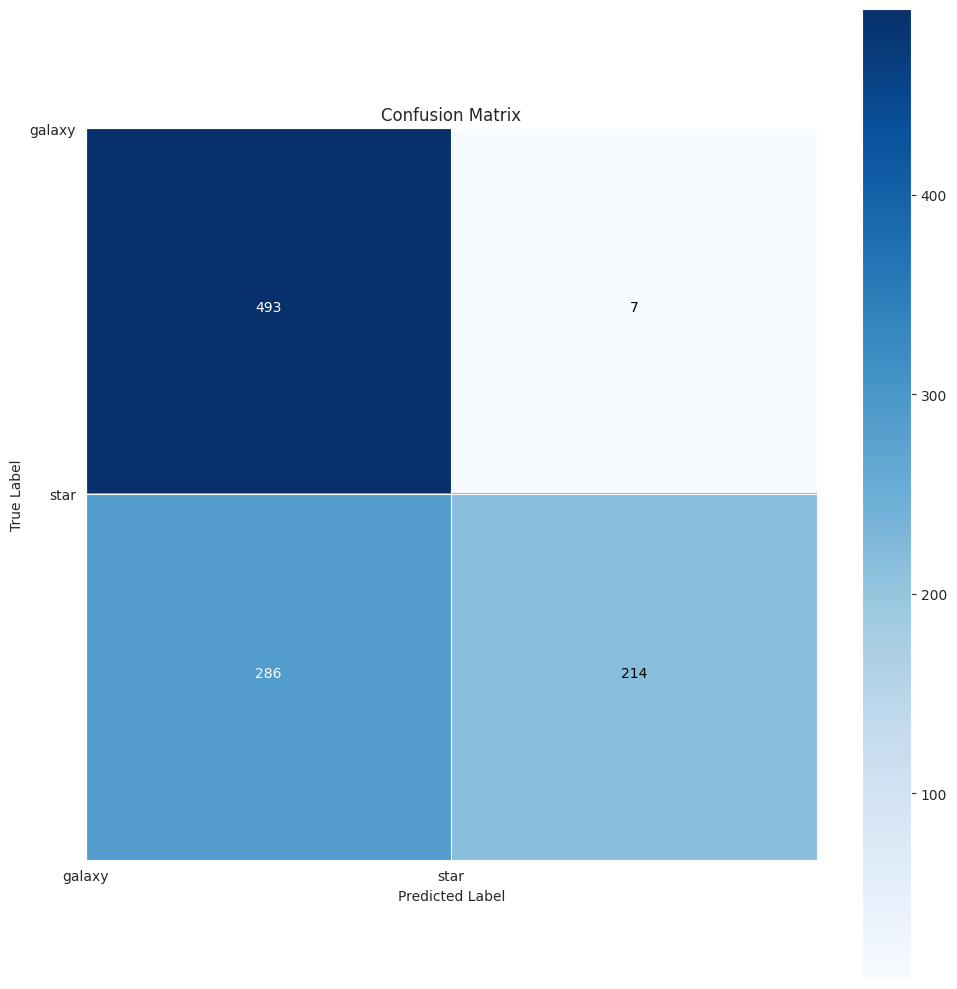

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks - 0.5, classes)
plt.yticks(tick_marks - 0.5, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

# 2️⃣ **VGG16**

In [ ]:
from keras.applications import VGG16
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model

# Model VGG16 tanpa fully connected layer
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=img_shape)
vgg16_base.trainable = False

inputs = Input(shape=img_shape)

# VGG-16 Layer
x = vgg16_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(1, activation='sigmoid')(x)

# Membuat model
vgg16_model = Model(inputs, outputs)


In [ ]:
vgg16_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_vgg16 = vgg16_model.fit(train_gen, epochs=epochs, validation_data=valid_gen, callbacks=[callbacks])

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 100s 261ms/step - accuracy: 0.8020 - loss: 0.4325 - val_accuracy: 0.9200 - val_loss: 0.2141
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 99s 218ms/step - accuracy: 0.9136 - loss: 0.2435 - val_accuracy: 0.9180 - val_loss: 0.2036
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 57s 221ms/step - accuracy: 0.9162 - loss: 0.2238 - val_accuracy: 0.9270 - val_loss: 0.1929
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 56s 219ms/step - accuracy: 0.9209 - loss: 0.2173 - val_accuracy: 0.9290 - val_loss: 0.1807
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 56s 217ms/step - accuracy: 0.9255 - loss: 0.2016 - val_accuracy: 0.9260 - val_loss: 0.1918
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 215ms/step - accuracy: 0.9258 - loss: 0.2027 - val_accuracy: 0.9330 - val_loss: 0.1752
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 215ms/step - accuracy: 0.9316 - loss: 0.1898 - val_accuracy: 0.9250 - val_loss: 0.1871
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 56s 217ms/step - accuracy: 0.9294 - loss: 

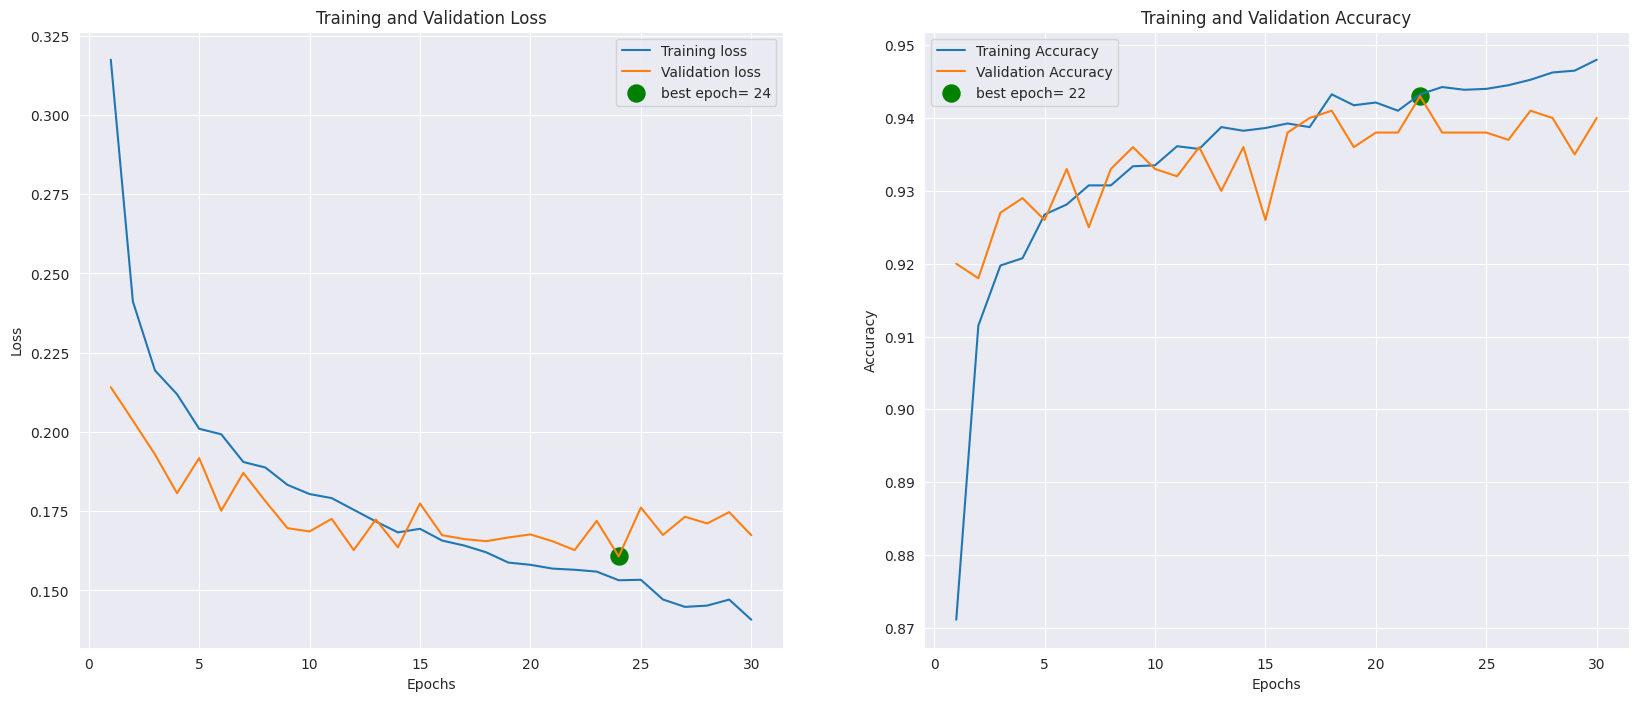

In [ ]:
tr_acc = history_vgg16.history['accuracy']
tr_loss = history_vgg16.history['loss']
val_acc = history_vgg16.history['val_accuracy']
val_loss = history_vgg16.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
# plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, label= 'Training Accuracy')
plt.plot(Epochs, val_acc, label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'green', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, label= 'Training loss')
plt.plot(Epochs, val_loss, label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'green', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
loss, accuracy = vgg16_model.evaluate(valid_gen)
print("Accuracy score:", accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - accuracy: 0.9384 - loss: 0.1685
Accuracy score: 0.9399999976158142


In [ ]:
train_score = vgg16_model.evaluate(train_gen, steps=train_gen.samples // batch_size, verbose=1)
valid_score = vgg16_model.evaluate(valid_gen, steps=valid_gen.samples // batch_size, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]:.4f}")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]:.4f}")
print('-' * 20)


250/250 ━━━━━━━━━━━━━━━━━━━━ 49s 194ms/step - accuracy: 0.9566 - loss: 0.1198
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.9313 - loss: 0.1759
Train Loss: 0.1176
Train Accuracy: 0.9574
--------------------
Validation Loss: 0.1683
Validation Accuracy: 0.9395
--------------------


In [ ]:
preds = vgg16_model.predict(test_gen)
y_pred = np.round(preds).astype(int)

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 226ms/step


In [ ]:
print(classification_report(test_gen.classes, y_pred, target_names=classes))

              precision    recall  f1-score   support

      galaxy       0.94      0.94      0.94       500
        star       0.94      0.94      0.94       500

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



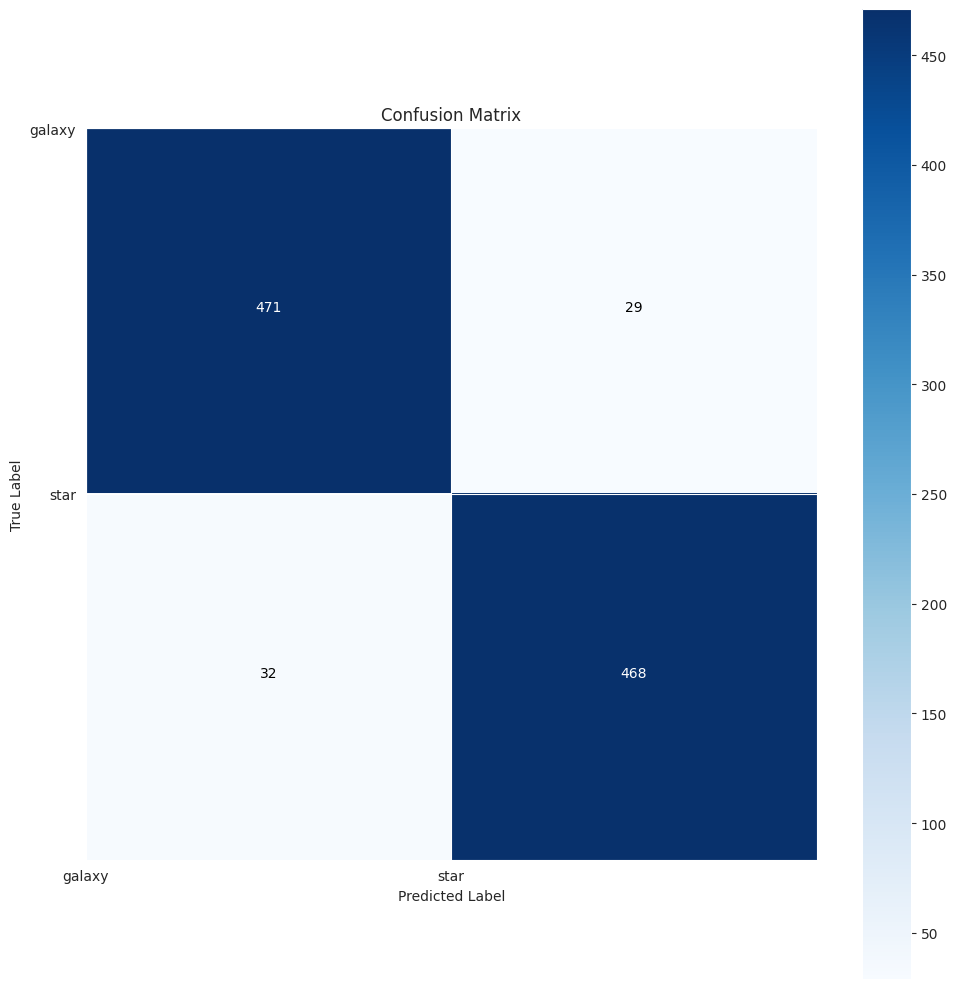

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks - 0.5, classes)
plt.yticks(tick_marks - 0.5, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

# **3️⃣ MobileNetV2**

In [ ]:
from keras.applications import MobileNetV2
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model

mobilenetv2_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=img_shape)
mobilenetv2_base.trainable = False

# Definisi input
inputs = Input(shape=img_shape)

x = mobilenetv2_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(1, activation='sigmoid')(x)

mobilenetv2_model = Model(inputs, outputs)

In [ ]:
mobilenetv2_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_mobilenetv2 = mobilenetv2_model.fit(train_gen, epochs=epochs, validation_data=valid_gen, callbacks=[callbacks])

Epoch 1/30
  1/250 ━━━━━━━━━━━━━━━━━━━━ 1:01:20 15s/step - accuracy: 0.5312 - loss: 0.7829

W0000 00:00:1724228093.511803    1840 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.7320 - loss: 0.5524

W0000 00:00:1724228144.769818    1842 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


250/250 ━━━━━━━━━━━━━━━━━━━━ 76s 246ms/step - accuracy: 0.7322 - loss: 0.5519 - val_accuracy: 0.8220 - val_loss: 0.4162
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 54s 212ms/step - accuracy: 0.8032 - loss: 0.4327 - val_accuracy: 0.8110 - val_loss: 0.3971
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 216ms/step - accuracy: 0.8080 - loss: 0.4095 - val_accuracy: 0.8260 - val_loss: 0.3753
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 216ms/step - accuracy: 0.8081 - loss: 0.4132 - val_accuracy: 0.8440 - val_loss: 0.3576
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 216ms/step - accuracy: 0.8173 - loss: 0.3962 - val_accuracy: 0.8400 - val_loss: 0.3514
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 56s 218ms/step - accuracy: 0.8265 - loss: 0.3775 - val_accuracy: 0.8510 - val_loss: 0.3477
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 215ms/step - accuracy: 0.8388 - loss: 0.3697 - val_accuracy: 0.8520 - val_loss: 0.3419
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 56s 217ms/step - accuracy: 0.8426 - loss: 0.3634 - val

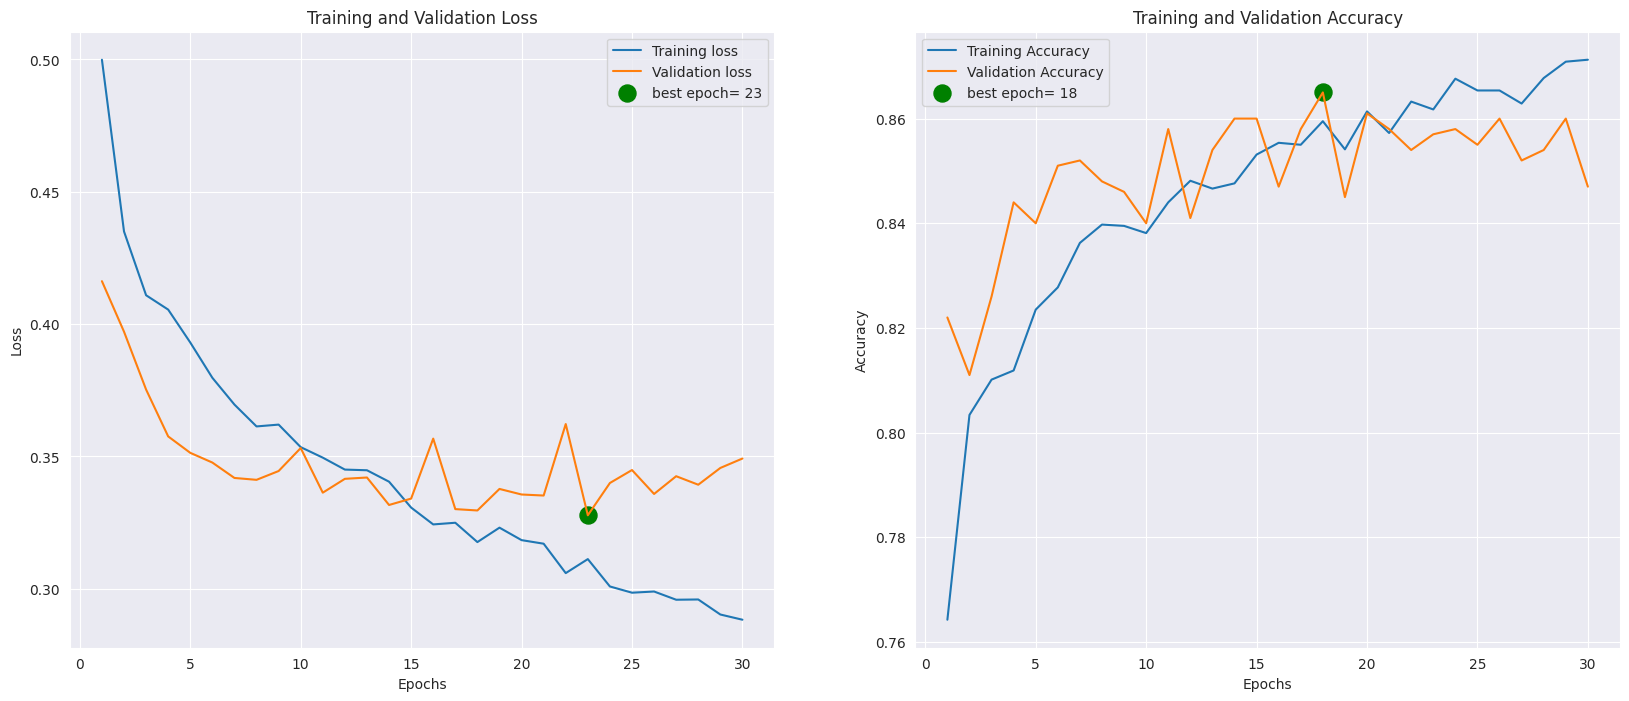

In [ ]:
tr_acc = history_mobilenetv2.history['accuracy']
tr_loss = history_mobilenetv2.history['loss']
val_acc = history_mobilenetv2.history['val_accuracy']
val_loss = history_mobilenetv2.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
# plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, label= 'Training Accuracy')
plt.plot(Epochs, val_acc, label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'green', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, label= 'Training loss')
plt.plot(Epochs, val_loss, label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'green', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
loss, accuracy = mobilenetv2_model.evaluate(valid_gen)
print("Accuracy score:", accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step - accuracy: 0.8448 - loss: 0.3338
Accuracy score: 0.847000002861023


In [ ]:
train_score = mobilenetv2_model.evaluate(train_gen, steps=train_gen.samples // batch_size, verbose=1)
valid_score = mobilenetv2_model.evaluate(valid_gen, steps=valid_gen.samples // batch_size, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]:.4f}")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]:.4f}")
print('-' * 20)


250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 192ms/step - accuracy: 0.8897 - loss: 0.2561
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - accuracy: 0.8472 - loss: 0.3514
Train Loss: 0.2539
Train Accuracy: 0.8942
--------------------
Validation Loss: 0.3474
Validation Accuracy: 0.8478
--------------------


In [ ]:
preds = mobilenetv2_model.predict(test_gen)
y_pred = np.round(preds).astype(int)

 1/32 ━━━━━━━━━━━━━━━━━━━━ 1:39 3s/step

W0000 00:00:1724229827.792864    1842 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 309ms/step


In [ ]:
print(classification_report(test_gen.classes, y_pred, target_names=classes))

              precision    recall  f1-score   support

      galaxy       0.85      0.79      0.82       500
        star       0.81      0.86      0.83       500

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000



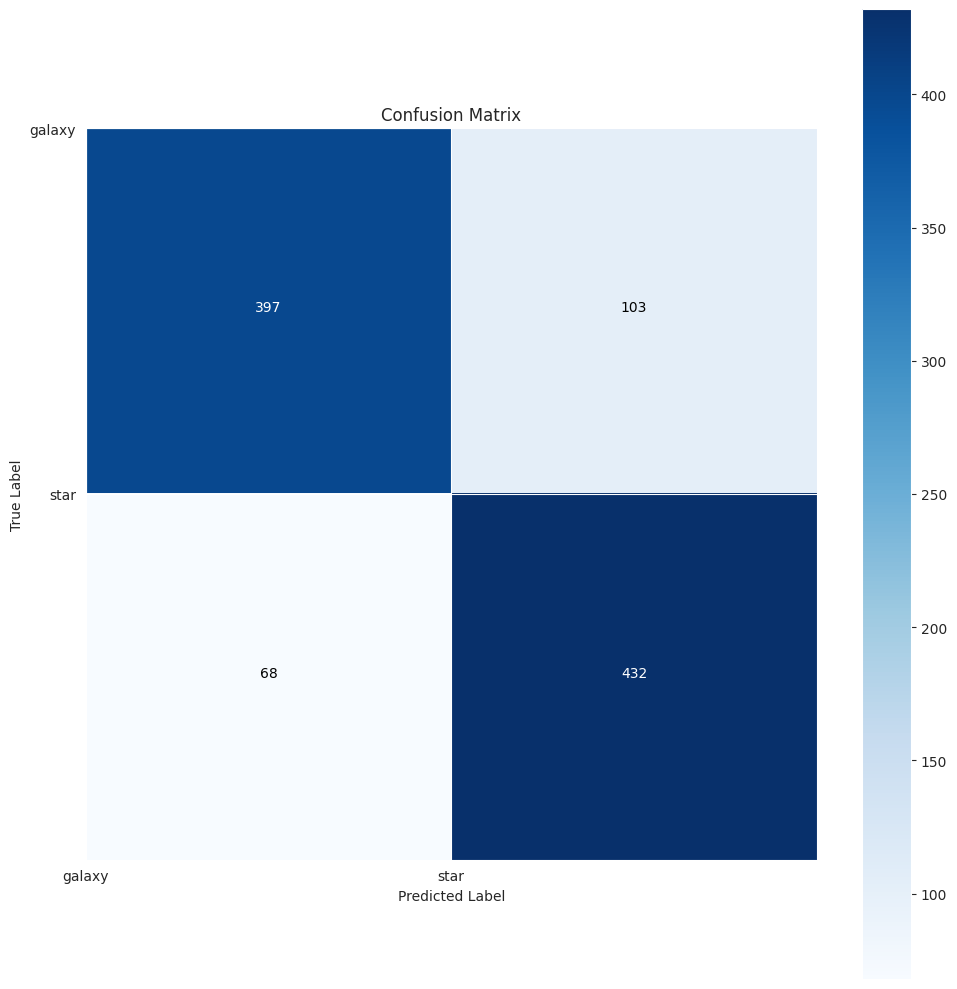

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks - 0.5, classes)
plt.yticks(tick_marks - 0.5, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()